<a href="https://colab.research.google.com/github/ykitaguchi77/pytorch-models/blob/master/%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92_EfficientNet_Gravcont.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EfficientNet

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Google driveのデータをマウント

In [2]:
'''
grav: 甲状腺眼症
cont: コントロール
黒の空白を挿入することにより225px*225pxの画像を生成、EfficientNetを用いて転移学習
－－－－－－－－－－－－－－
アップデータするデータの構造
gravcont.zip ------grav
               |---cont
'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

#gravcont_original.zipを解凍
!date -R
!unzip -qq drive/My\ Drive/Deep_learning/gravcont_processed.zip
!date -R
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Thu, 23 Apr 2020 11:03:03 +0000
Thu, 23 Apr 2020 11:03:08 +0000
drive  gravcont_processed  sample_data


#データセットの振り分け
"content/learning/"のフォルダ内に、"tranin"、"val"フォルダを作り、データを振り分ける

In [3]:
path = '/content/gravcont_processed/'
classes = os.listdir(path)
print(classes)

#os.makedirs('/learning', exist_ok=True)

list = [0] * len(classes)
train = [0] * len(classes)
val = [0] * len(classes)
k=0
for i in classes:
    list[k] = os.listdir(path + i)
    train[k] = random.sample(list[k], int(len(list[k])*0.8))
    val[k] = [x for x in list[k] if x not in train[k]]
    os.makedirs('learning/train/'+i, exist_ok=True) #trainのフォルダを作成
    os.makedirs('learning/val/'+i, exist_ok=True) #valのフォルダを作成
    for j in train[k]:
          shutil.move(path+i+'/'+j, 'learning/train/'+i)
    for j in val[k]:
          shutil.move(path+i+'/'+j, 'learning/val/'+i)

['cont', 'grav']


In [4]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/learning'
n_samples = len(data_dir)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path='/content/learning/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path='/content/learning/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))

['cont', 'grav']
cont_train:256
grav_train:252
cont_val:64
grav_val:63
training data set_total：508
validating data set_total：127


#少数の画像を可視化

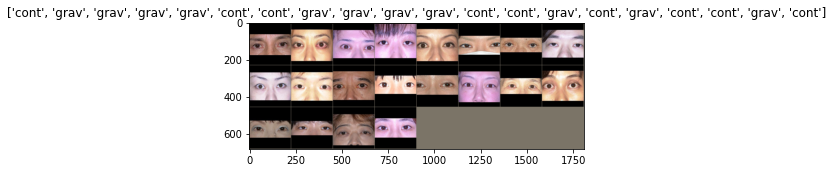

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Train models with early stopping class

In [0]:
#Defining early stopping class
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


#Train models
def train_model(model, criterion, optimizer, scheduler, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            
            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
                scheduler.step()
                print('epoch:{}, lr:{}'.format(epoch, scheduler.get_lr()[0]))
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':    
            early_stopping(epoch_loss, model)
                
            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss


#Visualize model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#Define EfficientNet
※pretrained modelを用いているので、ここは不要

In [0]:
# Swish activation    
class Swish(nn.Module):                                    
    def forward(self, x):
        return x * torch.sigmoid(x)


# Squeeze Excitation module
class SEblock(nn.Module):                                 
    def __init__(self, ch_in, ch_sq):
        super(SEblock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch_in, ch_sq, 1),
            Swish(),
            nn.Conv2d(ch_sq, ch_in, 1),
        )
        self.se.apply(weights_init)

    def forward(self, x):
        return x * torch.sigmoid(self.se(x))

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)


#ConvBN module
class ConvBN(nn.Module):
    def __init__(self, ch_in, ch_out, kernel_size,
                 stride=1, padding=0, groups=1):
        super(ConvBN, self).__init__()
        self.layers = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size,
                          stride, padding, groups=groups, bias=False),
                nn.BatchNorm2d(ch_out),
        )
        self.layers.apply(weights_init)

    def forward(self, x):
        return self.layers(x)


#Drop Connect layer
class DropConnect(nn.Module):
    def __init__(self, drop_rate):
        super(DropConnect, self).__init__()
        self.drop_rate = drop_rate

    def forward(self, x):
        if self.training:
            keep_rate = 1.0 - self.drop_rate
            r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
            r += keep_rate
            mask = r.floor()
            return x.div(keep_rate) * mask
        else:
            return x


#BM module
class BMConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out,
                 expand_ratio, stride, kernel_size,
                 reduction_ratio=4, drop_connect_rate=0.2):
        super(BMConvBlock, self).__init__()
        self.use_residual = (ch_in==ch_out) & (stride==1)
        ch_med = int(ch_in * expand_ratio)
        ch_sq = max(1, ch_in//reduction_ratio)

        # define network                                                        
        if expand_ratio != 1.0:
            layers = [ConvBN(ch_in, ch_med, 1),Swish()]
        else:
            layers = []

        layers.extend([
            ConvBN(ch_med, ch_med, kernel_size, stride=stride,
                   padding=(kernel_size-1)//2, groups=ch_med), # depth-wise    
            Swish(),
            SEblock(ch_med, ch_sq), # Squeeze Excitation                        
            ConvBN(ch_med, ch_out, 1), # pixel-wise                             
        ])

        if self.use_residual:
            self.drop_connect = DropConnect(drop_connect_rate)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_residual:
            return x + self.drop_connect(self.layers(x))
        else:
            return self.layers(x)


#Flatten layer
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)


#EfficientNet
class EfficientNet(nn.Module):
    def __init__(self, width_mult=1.0, depth_mult=1.0,
                 resolution=False, dropout_rate=0.2, 
                 input_ch=3, num_classes=1000):
        super(EfficientNet, self).__init__()

        # expand_ratio, channel, repeats, stride, kernel_size                   
        settings = [
            [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112                   
            [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56                   
            [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28                   
            [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14                   
            [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14                   
            [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7                   
            [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7]                  
        ]

        ch_out = int(math.ceil(32*width_mult))
        features = [nn.AdaptiveAvgPool2d(resolution)] if resolution else []
        features.extend([ConvBN(input_ch, ch_out, 3, stride=2), Swish()])

        ch_in = ch_out
        for t, c, n, s, k in settings:
            ch_out  = int(math.ceil(c*width_mult))
            repeats = int(math.ceil(n*depth_mult))
            for i in range(repeats):
                stride = s if i==0 else 1
                features.extend([BMConvBlock(ch_in, ch_out, t, stride, k)])
                ch_in = ch_out

        ch_last = int(math.ceil(1280*width_mult))
        features.extend([ConvBN(ch_in, ch_last, 1), Swish()])

        self.features = nn.Sequential(*features)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Dropout(dropout_rate))
        self.fc = nn.Linear(ch_last, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        x = self.fc(x)
        return x


#EfficientNetB0からB7まで
def _efficientnet(w_mult, d_mult, resolution, drop_rate,
                  input_ch, num_classes=1000):
    model = EfficientNet(w_mult, d_mult,
                         resolution, drop_rate,
                         input_ch, num_classes)
    return model


def efficientnet_b0(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.0, 1.0, 224, 0.2)              
    return _efficientnet(1.0, 1.0, None, 0.2, input_ch, num_classes)

def efficientnet_b1(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.0, 1.1, 240, 0.2)              
    return _efficientnet(1.0, 1.1, None, 0.2, input_ch, num_classes)

def efficientnet_b2(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.1, 1.2, 260, 0.3)              
    return _efficientnet(1.1, 1.2, None, 0.3, input_ch, num_classes)

def efficientnet_b3(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.2, 1.4, 300, 0.3)              
    return _efficientnet(1.2, 1.4, None, 0.3, input_ch, num_classes)

def efficientnet_b4(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.4, 1.8, 380, 0.4)              
    return _efficientnet(1.4, 1.8, None, 0.4, input_ch, num_classes)

def efficientnet_b5(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.6, 2.2, 456, 0.4)              
    return _efficientnet(1.6, 2.2, None, 0.4, input_ch, num_classes)

def efficientnet_b6(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.8, 2.6, 528, 0.5)              
    return _efficientnet(1.8, 2.6, None, 0.5, input_ch, num_classes)

def efficientnet_b7(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (2.0, 3.1, 600, 0.5)              
    return _efficientnet(2.0, 3.1, None, 0.5, input_ch, num_classes)


#Convnetを再調整する

In [0]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet 

model_ft = EfficientNet.from_pretrained('efficientnet-b7')
num_ftrs = model_ft._fc.in_features
model_ft._fc = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[5, 12, 20, 30], gamma=0.1)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b7


#訓練と評価

In [0]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, patience=5, num_epochs=50)

Epoch 0/49
----------
epoch:0, lr:0.01
train Loss: 1.0432 Acc: 0.5039
val Loss: 0.7018 Acc: 0.6000
Validation loss decreased (inf --> 0.701773).  Saving model ...

Epoch 1/49
----------
epoch:1, lr:0.01
train Loss: 0.7453 Acc: 0.6406
val Loss: 0.8992 Acc: 0.3769
EarlyStopping counter: 1 out of 5

Epoch 2/49
----------
epoch:2, lr:0.01
train Loss: 0.7565 Acc: 0.6113
val Loss: 0.4944 Acc: 0.7692
Validation loss decreased (0.701773 --> 0.494410).  Saving model ...

Epoch 3/49
----------
epoch:3, lr:0.01
train Loss: 0.6293 Acc: 0.6797
val Loss: 0.6587 Acc: 0.6154
EarlyStopping counter: 1 out of 5

Epoch 4/49
----------
epoch:4, lr:0.0001
train Loss: 0.6167 Acc: 0.7012
val Loss: 0.4387 Acc: 0.7923
Validation loss decreased (0.494410 --> 0.438716).  Saving model ...

Epoch 5/49
----------
epoch:5, lr:0.001
train Loss: 0.4672 Acc: 0.7793
val Loss: 0.4062 Acc: 0.8308
Validation loss decreased (0.438716 --> 0.406156).  Saving model ...

Epoch 6/49
----------
epoch:6, lr:0.001
train Loss: 0.3961

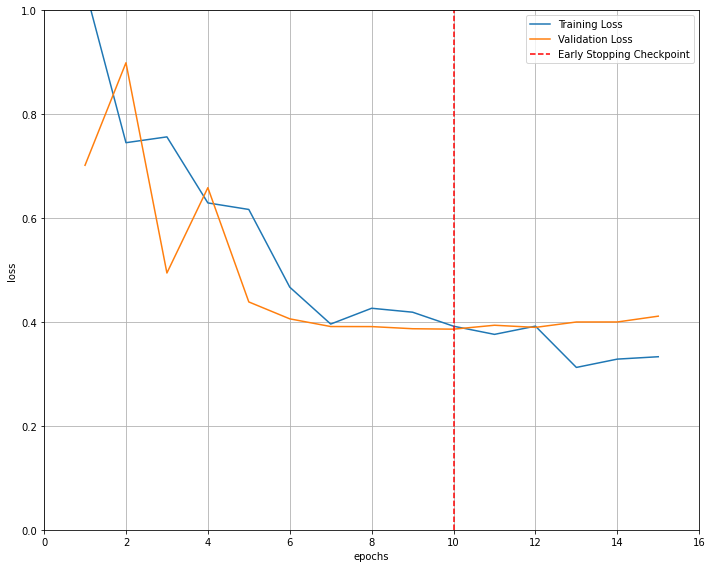

In [0]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

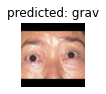

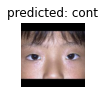

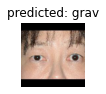

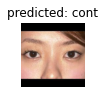

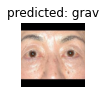

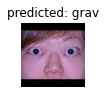

In [0]:
visualize_model(model_ft)

#Calcurate Accuracy
・True positive (TN)<br>
・False positive (FP)<br>
・True negative (TN)<br>
・False negative (FN)<br>

Accuracy = (TP + TN)/ (TP + TN + FP + FN)<br>
Precision = TP/(FP + TP) ※positive predictive value<br>
Recall = TP/(TP + FN)　※sensitivity<br>
Specificity = TN/(FP + TN)<br>
F_value = (2RecallPrecision)/(Recall+Precision)<br>

In [0]:
#valフォルダ内のファイル名を取得
image_path = glob.glob("/content/data/hymenoptera_data/val/*/*")
random.shuffle(image_path)  #表示順をランダムにする
print(len(image_path))
print(image_path) 



"""
#ファイル名よりラベルを抜き出し、'class_name'と定義
class_name = []
class_path = glob.glob('/content/drive/My Drive/Deep_learning/applstra/val/*')
for i in class_path:
    class_name.append(os.path.basename(i))  
print(class_name)
"""

130
['/content/data/hymenoptera_data/val/grav/8198.jpg', '/content/data/hymenoptera_data/val/grav/6478.jpg', '/content/data/hymenoptera_data/val/grav/6432.JPG', '/content/data/hymenoptera_data/val/cont/1512.JPG', '/content/data/hymenoptera_data/val/grav/7527.JPG', '/content/data/hymenoptera_data/val/grav/7870.jpg', '/content/data/hymenoptera_data/val/cont/1443.JPG', '/content/data/hymenoptera_data/val/cont/1541.jpg', '/content/data/hymenoptera_data/val/cont/1495.jpg', '/content/data/hymenoptera_data/val/cont/1369.jpg', '/content/data/hymenoptera_data/val/cont/1498.JPG', '/content/data/hymenoptera_data/val/grav/6965.jpg', '/content/data/hymenoptera_data/val/cont/1462.JPG', '/content/data/hymenoptera_data/val/cont/1372.jpg', '/content/data/hymenoptera_data/val/grav/6654.jpg', '/content/data/hymenoptera_data/val/grav/7349.jpg', '/content/data/hymenoptera_data/val/grav/6599.jpg', '/content/data/hymenoptera_data/val/grav/7781.JPG', '/content/data/hymenoptera_data/val/grav/7534.JPG', '/conte

"\n#ファイル名よりラベルを抜き出し、'class_name'と定義\nclass_name = []\nclass_path = glob.glob('/content/drive/My Drive/Deep_learning/applstra/val/*')\nfor i in class_path:\n    class_name.append(os.path.basename(i))  \nprint(class_name)\n"

#画像とラベル表示のための関数を定義

In [0]:
#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      label = os.path.basename(os.path.dirname(image_path))
      return(image_name, label)

'''
#変形後の画像を表示
def image_transform(image_path):

    image=Image.open(image_path)

    
    #変形した画像を表示する
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
    image_transformed = transform(image)
    plt.imshow(np.array(image_transformed))
'''

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def image_eval(image_tensor, label):
    output = model_ft(image_tensor)
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)

    #正解は青色、不正解は赤色で表示する
    _, pred = torch.max(output, 1)
    model_pred = class_names[pred]

    return(model_pred)  #class_nameの番号で出力される

def showImage(image_path):
    #画像のインポート
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)

def calculateAccuracy (TP, TN, FP, FN):
    accuracy = (TP + TN)/ (TP + TN + FP + FN)
    precision  = TP/(FP + TP)
    recall = TP/(TP + FN)
    specificity = TN/(FP + TN)
    f_value = (2*recall*precision)/(recall+precision)
    return(accuracy, precision, recall, specificity, f_value)

In [0]:
TP, FP, TN, FN, TP, FP, TN, FN = [0,0,0,0,0,0,0,0]
image_name_list = []
label_list = []
model_pred_list = []
hum_pred_list = []

for i in image_path:
      image_name, label = getlabel(i)  #画像の名前とラベルを取得
      image_tensor = image_transform(i)  #予測のための画像下処理
      model_pred = image_eval(image_tensor, label)  #予測結果を出力   
      print('Image: '+ image_name)
      print('Label: '+ label)
      print('Pred: '+ model_pred)
      showImage(i)  #画像を表示
      print() #空白行を入れる
      time.sleep(0.1)

      image_name_list.append(image_name)
      label_list.append(label)
      model_pred_list.append(model_pred)

      if label == class_names[0]:
          if model_pred == class_names[0]:
              TP += 1
          else:
              FN += 1
      elif label == class_names[1]:
          if model_pred == class_names[1]:
              TN += 1
          else:
              FP += 1

In [0]:
#Accuracyを計算
accuracy, precision, recall, specificity, f_value = calculateAccuracy (TP, TN, FP, FN)
print('Accuracy: ' + str(accuracy))
print('Precision (positive predictive value): ' + str(precision))
print('Recall (sensitivity): ' + str(recall))
print('Specificity: ' + str(specificity))
print('F_value: ' + str(f_value))

Accuracy: 0.8692307692307693
Precision (positive predictive value): 0.8428571428571429
Recall (sensitivity): 0.9076923076923077
Specificity: 0.8307692307692308
F_value: 0.8740740740740741


#ネットワークの保存

In [0]:
#ネットワークの保存
PATH = '/content/drive/My Drive/Deep_learning/EfficientNet-b7.pth'
torch.save(model_ft.state_dict(), PATH)